<a href="https://colab.research.google.com/github/Mawanrs/UAS_AI/blob/main/UAS_AI_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

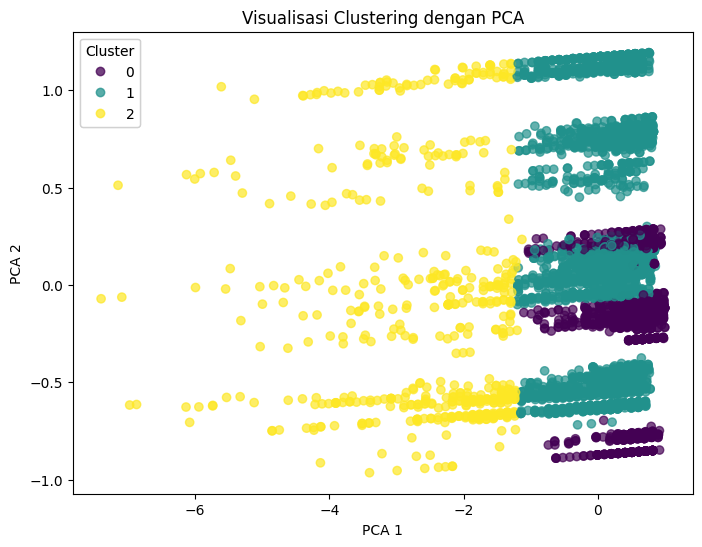

Distribusi label sebelum oversampling:
 cluster
1    3267
0    1885
2     548
Name: count, dtype: int64
Distribusi label setelah oversampling:
 cluster
0    3267
1    3267
2    3267
Name: count, dtype: int64


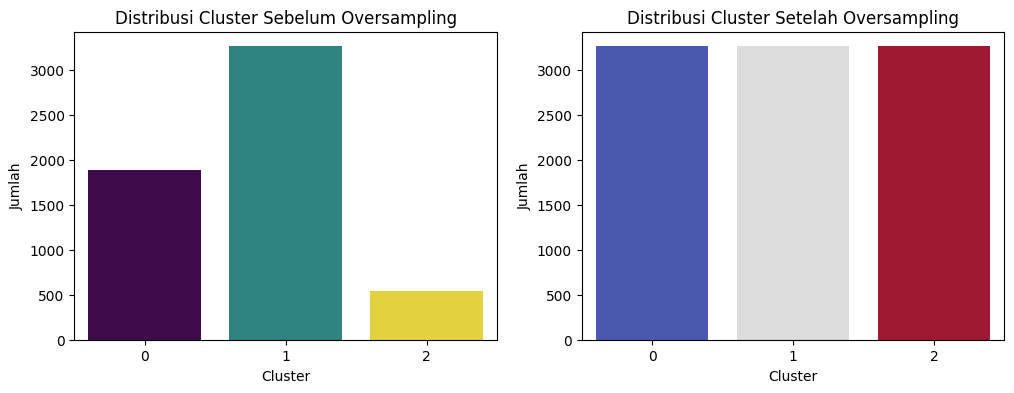

Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       679
           1       1.00      1.00      1.00       622
           2       1.00      1.00      1.00       660

    accuracy                           1.00      1961
   macro avg       1.00      1.00      1.00      1961
weighted avg       1.00      1.00      1.00      1961



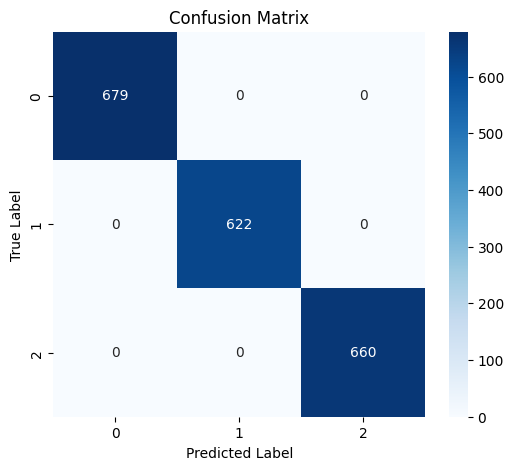

Accuracy tanpa clustering: 0.9973684210526316
Classification Report tanpa clustering:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       374
           1       1.00      1.00      1.00       646
           2       1.00      0.97      0.99       120

    accuracy                           1.00      1140
   macro avg       1.00      0.99      1.00      1140
weighted avg       1.00      1.00      1.00      1140



In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# - Preprocessing Data
# 1. Kumpulkan dataset
df = pd.read_csv('/netflix_titles.csv')  # Sesuaikan dengan lokasi dataset

# 2. Bersihkan data (hindari chained assignment dengan .loc)
df.loc[:, 'country'] = df['country'].fillna('Unknown')
df.loc[:, 'rating'] = df['rating'].fillna(df['rating'].mode()[0])
df.loc[:, 'duration'] = df['duration'].fillna('0 min')
df = df.dropna()  # Hapus hanya baris yang tidak bisa diisi

# 3. Encoding categorical variables (hanya yang relevan)
categorical_cols = ['type', 'rating', 'country', 'listed_in']
df_encoded = pd.get_dummies(df[categorical_cols], drop_first=True)

# 4. Normalisasi/transformasi data numerik
scaler = StandardScaler()
df_encoded[['release_year']] = scaler.fit_transform(df[['release_year']])

# - Clustering
# 1. Pilih algoritma clustering (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# 2. Jalankan algoritma clustering & simpan hasil klaster
df_encoded['cluster'] = kmeans.fit_predict(df_encoded)

# 3. Visualisasi Hasil Clustering dengan PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded.drop(columns=['cluster']))

fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], c=df_encoded['cluster'], cmap="viridis", alpha=0.7)
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
ax.set_title("Visualisasi Clustering dengan PCA")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.show()

# - Penggabungan dengan Machine Learning
# 1. Pilih model machine learning (Klasifikasi)
ml_features = [col for col in df_encoded.columns if col != 'cluster']
X = df_encoded[ml_features]
y = df_encoded['cluster']  # Menggunakan hasil clustering sebagai target sementara

# 2. Mengatasi ketidakseimbangan data dengan SMOTE
print("Distribusi label sebelum oversampling:\n", y.value_counts())

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Distribusi label setelah oversampling:\n", pd.Series(y_resampled).value_counts())

# Visualisasi distribusi cluster sebelum dan sesudah oversampling
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=y, hue=y, ax=ax[0], palette="viridis", legend=False)
ax[0].set_title("Distribusi Cluster Sebelum Oversampling")
ax[0].set_xlabel("Cluster")
ax[0].set_ylabel("Jumlah")

sns.countplot(x=y_resampled, hue=y_resampled, ax=ax[1], palette="coolwarm", legend=False)
ax[1].set_title("Distribusi Cluster Setelah Oversampling")
ax[1].set_xlabel("Cluster")
ax[1].set_ylabel("Jumlah")

plt.show()

# 3. Membagi dataset menjadi train-test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 4. Latih model machine learning (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 5. Evaluasi model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# 6. Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
labels = sorted(pd.Series(y_resampled).unique())  # Pastikan label terurut

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")
plt.show()

# - Evaluasi & Pengoptimalan: Bandingkan dengan model tanpa clustering
if 'cluster' in df_encoded.columns:
    X_no_cluster = df_encoded.drop(columns=['cluster'])
    X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(X_no_cluster, y, test_size=0.2, random_state=42)

    model_nc = RandomForestClassifier(random_state=42)
    model_nc.fit(X_train_nc, y_train_nc)
    y_pred_nc = model_nc.predict(X_test_nc)

    print("Accuracy tanpa clustering:", accuracy_score(y_test_nc, y_pred_nc))
    print("Classification Report tanpa clustering:\n", classification_report(y_test_nc, y_pred_nc, zero_division=1))
else:
    print("Kolom 'cluster' tidak ditemukan! Pastikan proses clustering telah dijalankan dengan benar.")
